# From Neurons to Networks: Exploring Deep Learning Algorithms

Roderick Perez, Ph.D.
OMV

---

In [1]:
!pip install yfinance tensorflow matplotlib scikit-learn

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import datetime

2024-10-22 22:09:33.022438: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-22 22:09:33.040812: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-22 22:09:33.201532: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-22 22:09:33.344458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 22:09:33.500019: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

1) Load Financial Data from Yahoo Finance

In [3]:
# Function to load financial data
def load_financial_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Adj Close'].values.reshape(-1, 1), data  # Returning adjusted close prices

In [4]:
# Example: Load NVIDIA stock data
ticker = "NVDA"
start_date = "2015-01-01"
end_date = datetime.date.today().strftime("%Y-%m-%d")
data, raw_data = load_financial_data(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


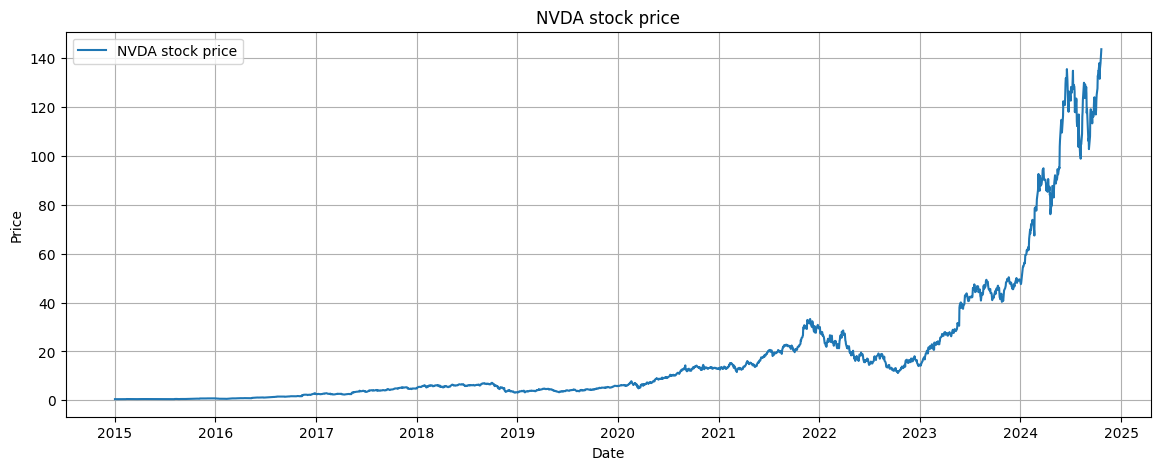

In [5]:
# Plot the data
plt.figure(figsize=(14, 5))
plt.plot(raw_data.index, data, label=f"{ticker} stock price")
plt.title(f"{ticker} stock price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

2. Split Dataset into Train, Test, and Validation Sets

We'll split the data into training (60%), testing (20%), and validation (20%) sets. Data will be scaled using MinMaxScaler for LSTM input.

In [6]:
# Normalize the data to range [0, 1] for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into training, validation, and test sets
train_size = int(len(scaled_data) * 0.6)
test_size = int(len(scaled_data) * 0.2)
val_size = len(scaled_data) - train_size - test_size

train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:train_size + test_size]
val_data = scaled_data[train_size + test_size:]

print(f"Train size: {len(train_data)}, Test size: {len(test_data)}, Validation size: {len(val_data)}")

Train size: 1480, Test size: 493, Validation size: 494


3. Define Model Parameters (Learning Rate, Window Size, etc.)

In [7]:
# Hyperparameters
window_size = 60  # Number of days to look back
batch_size = 64
epochs = 10
learning_rate = 0.001

4. Prepare Data for LSTM and Define Model Architecture

In [8]:
# Function to create windows for LSTM input
def create_dataset(dataset, window_size):
    X, y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i + window_size])
        y.append(dataset[i + window_size])
    return np.array(X), np.array(y)

# Prepare the training, testing, and validation data
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)
X_val, y_val = create_dataset(val_data, window_size)

# Reshape X for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5. Show Model Summary

In [9]:
# Show model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

6. Train the Model

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 4.3289e-04 - val_loss: 0.0025
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 2.8765e-05 - val_loss: 0.0047
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.4958e-05 - val_loss: 0.0027
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.5321e-05 - val_loss: 0.0020
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.2927e-05 - val_loss: 0.0020
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 1.0049e-05 - val_loss: 0.0028
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.0568e-05 - val_loss: 0.0022
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 9.3782e-06 - val_loss: 0.0019
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 9.4907e-06 - val_loss: 0.0018
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 9.8071e-06 - val_loss: 0.0028


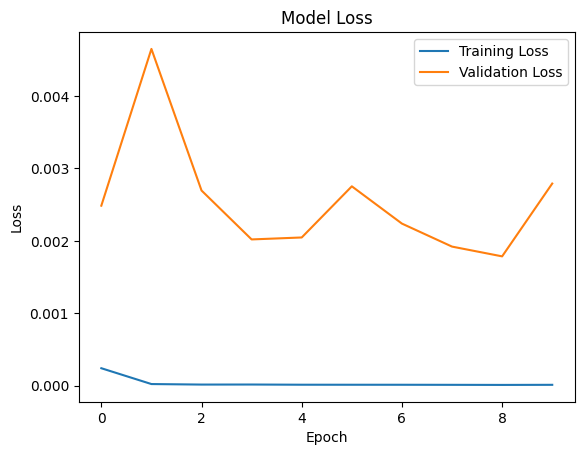

In [10]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

7. Save the Model

In [11]:
# Save the model
model.save("lstm_nvidia_model.h5")

8. Load the Model

In [12]:
# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model("lstm_nvidia_model.h5")

9. Make Predictions for Future Days

In [13]:
prediction_days = 365

In [14]:
# Function to predict future values
def predict_future_days(model, data, prediction_days, window_size):
    predictions = []
    last_window = data[-window_size:]
    
    for _ in range(prediction_days):
        input_data = last_window.reshape((1, window_size, 1))
        predicted_value = model.predict(input_data)
        predictions.append(predicted_value[0, 0])
        last_window = np.append(last_window[1:], predicted_value)

    return predictions

# Predict next 30 days
future_predictions = predict_future_days(loaded_model, scaled_data, prediction_days, window_size)

# Inverse scale the predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

10. Plot the Results (Training, Testing, Validation, and Predictions)

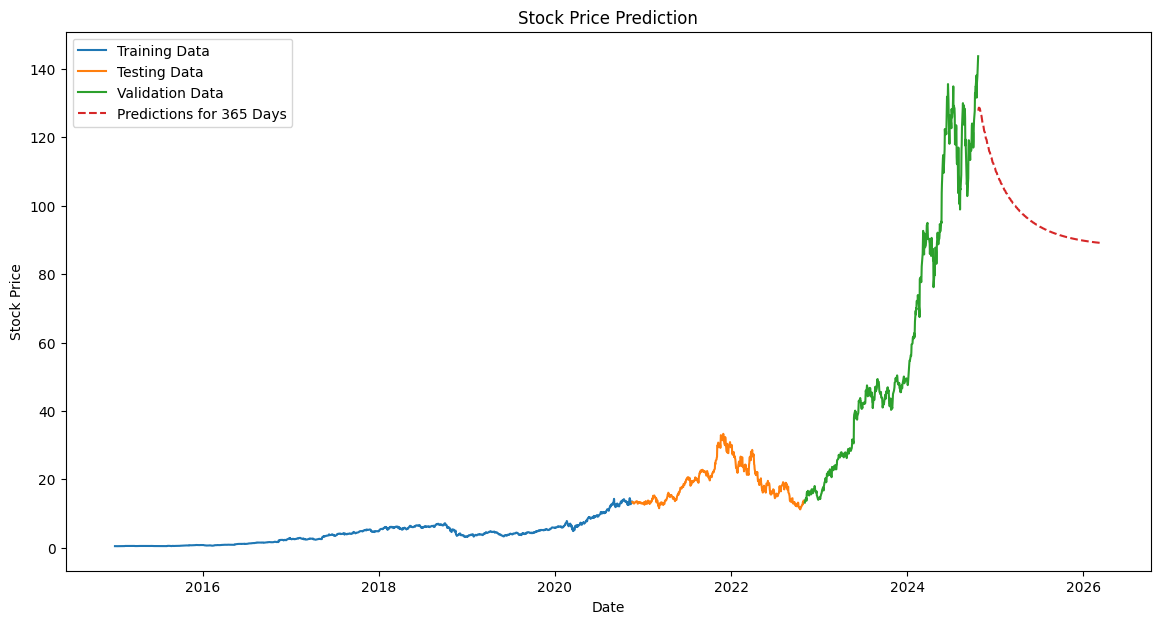

In [15]:
# Create a time-series plot of training, testing, validation, and future predictions

# Plot the training, testing, and validation data
plt.figure(figsize=(14, 7))
plt.plot(raw_data.index[:train_size], scaler.inverse_transform(train_data), label='Training Data')
plt.plot(raw_data.index[train_size:train_size + test_size], scaler.inverse_transform(test_data), label='Testing Data')
plt.plot(raw_data.index[train_size + test_size:], scaler.inverse_transform(val_data), label='Validation Data')

# Plot future predictions
prediction_index = pd.date_range(start=raw_data.index[-1], periods=prediction_days + 1, freq='B')[1:]
plt.plot(prediction_index, future_predictions, label=f'Predictions for {prediction_days} Days', linestyle='dashed')

plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

---

# EXTRA

In [16]:
!pip install keras-tuner

In [17]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

1) Define a Hypermodel for the LSTM

In this hypermodel, we are tuning the following hyperparameters:

* Units: The number of LSTM units in each LSTM layer (ranging from 32 to 256).
* Dropout Rate: The dropout percentage after each LSTM layer (ranging from 0.1 to 0.5).
* Learning Rate: The learning rate for the Adam optimizer (ranging from 0.0001 to 0.01).

In [18]:
# Hypermodel for Keras Tuner
def build_lstm_model(hp):
    model = Sequential()
    
    # Tuning the number of units in LSTM layers and Dropout rate
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32),
                   return_sequences=True, input_shape=(window_size, 1)))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32), return_sequences=False))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    
    # Tune the learning rate for Adam optimizer
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
    
    return model


2) Perform Grid Search with Keras Tuner

In [19]:
# Grid Search with Keras Tuner
def run_grid_search(X_train, y_train, X_val, y_val):
    tuner = kt.GridSearch(
        build_lstm_model,
        objective='val_loss',
        max_trials=5,  # Number of combinations to try
        executions_per_trial=2,  # Number of models to be built and evaluated for each trial
        directory='lstm_grid_search',
        project_name='lstm_tuning'
    )

    # Search for the best hyperparameters
    tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=64)
    
    # Get the best model and hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.get_best_models(num_models=1)[0]
    
    return best_hps, best_model


3) Perform Random Search with Keras Tuner

In [20]:
# Random Search with Keras Tuner
def run_random_search(X_train, y_train, X_val, y_val):
    tuner = kt.RandomSearch(
        build_lstm_model,
        objective='val_loss',
        max_trials=5,  # Number of combinations to try
        executions_per_trial=2,  # Number of models to be built and evaluated for each trial
        directory='lstm_random_search',
        project_name='lstm_tuning'
    )

    # Search for the best hyperparameters
    tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=64)
    
    # Get the best model and hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.get_best_models(num_models=1)[0]
    
    return best_hps, best_model


4) Display Best Hyperparameters

In [21]:
# Show the best hyperparameters
def show_best_hyperparameters(best_hps):
    print(f"Best number of units: {best_hps.get('units')}")
    print(f"Best dropout rate: {best_hps.get('dropout_rate')}")
    print(f"Best learning rate: {best_hps.get('learning_rate')}")


5) Main Execution with Tuning

In [22]:
# Example: Running Grid Search
best_hps_grid, best_model_grid = run_grid_search(X_train, y_train, X_val, y_val)
show_best_hyperparameters(best_hps_grid)

# Example: Running Random Search
best_hps_random, best_model_random = run_random_search(X_train, y_train, X_val, y_val)
show_best_hyperparameters(best_hps_random)


Reloading Tuner from lstm_grid_search/lstm_tuning/tuner0.json


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best number of units: 32
Best dropout rate: 0.1
Best learning rate: 0.0007943282347242816
Reloading Tuner from lstm_random_search/lstm_tuning/tuner0.json
Best number of units: 160
Best dropout rate: 0.30000000000000004
Best learning rate: 0.001023524596318175


6) Train both models with best hyperparameters


In [23]:
history_grid = best_model_grid.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))
history_random = best_model_random.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 3.2933e-05 - val_loss: 0.0022
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 9.0321e-06 - val_loss: 0.0015
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 8.0204e-06 - val_loss: 0.0014
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 8.0212e-06 - val_loss: 0.0014
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 7.6567e-06 - val_loss: 0.0014
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 7.7671e-06 - val_loss: 0.0013
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 8.1427e-06 - val_loss: 0.0018
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 7.3306e-06 - val_loss: 0.0022
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 8.2056e-06 - val_loss: 0.0016
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 7.7358e-06 - val_loss: 0.0012
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - loss: 1.7275e-04 - val_loss: 0.0047
Epoch 2/10
23/23 ━━

7) Plot the errors (loss) for both models on the same plot

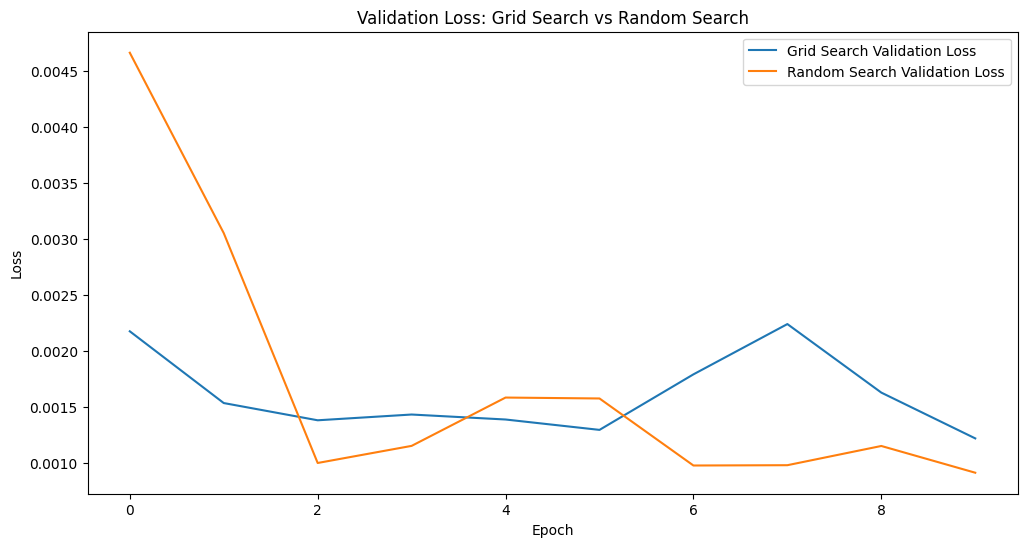

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(history_grid.history['val_loss'], label='Grid Search Validation Loss')
plt.plot(history_random.history['val_loss'], label='Random Search Validation Loss')
plt.title('Validation Loss: Grid Search vs Random Search')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

8) Save the final model (best from Grid Search)

In [25]:
best_model_grid.save("final_lstm_model.h5")

9. Load the Final Model

In [26]:
from tensorflow.keras.models import load_model

# Load the final model
final_model = load_model("final_lstm_model.h5")

10. Predict Future Values

In [27]:
# Predict the next 365 days
prediction_days = 365

In [28]:
# Function to predict future values
def predict_future_days(model, data, prediction_days, window_size):
    predictions = []
    last_window = data[-window_size:]
    
    for _ in range(prediction_days):
        input_data = last_window.reshape((1, window_size, 1))
        predicted_value = model.predict(input_data)
        predictions.append(predicted_value[0, 0])
        last_window = np.append(last_window[1:], predicted_value)

    return predictions

future_predictions = predict_future_days(final_model, scaled_data, prediction_days, window_size)

# Inverse scale the predictions (since we scaled the input data earlier)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

11. Plot the Final Results

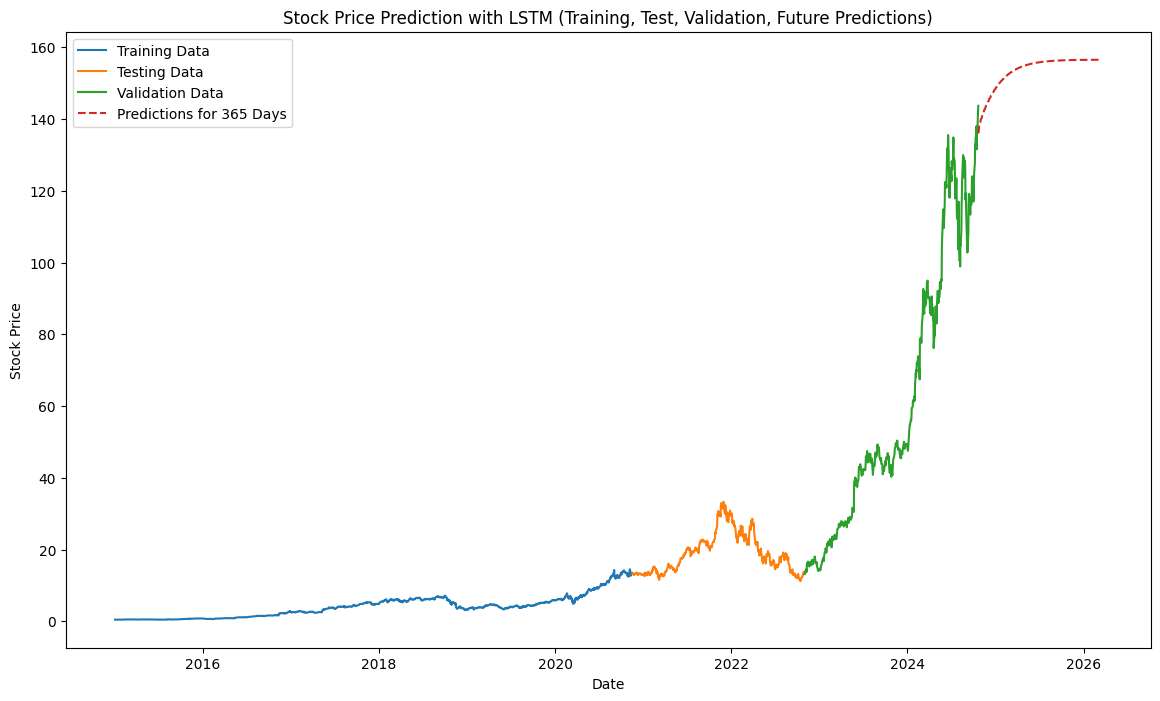

In [29]:
# Plot the training, testing, validation, and predicted future data
plt.figure(figsize=(14, 8))

# Plot the training data
plt.plot(raw_data.index[:train_size], scaler.inverse_transform(train_data), label='Training Data')

# Plot the testing data
plt.plot(raw_data.index[train_size:train_size + test_size], scaler.inverse_transform(test_data), label='Testing Data')

# Plot the validation data
plt.plot(raw_data.index[train_size + test_size:], scaler.inverse_transform(val_data), label='Validation Data')

# Plot the future predictions
future_index = pd.date_range(start=raw_data.index[-1], periods=prediction_days + 1, freq='B')[1:]
plt.plot(future_index, future_predictions, label=f'Predictions for {prediction_days} Days', linestyle='dashed')

plt.title('Stock Price Prediction with LSTM (Training, Test, Validation, Future Predictions)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()